In [1]:
import pandas as pd

from dpks.quant_matrix import QuantMatrix
from dpks.differential_testing import DifferentialTest

quant_matrix = QuantMatrix(
    quantification_file="../tests/input_files/de_matrix.tsv",
    design_matrix_file="../tests/input_files/de_design_matrix.tsv"
)



ModuleNotFoundError: No module named 'dpks'

In [4]:
compared_data = (
    quant_matrix.filter()
        .normalize(
            method="mean",
            log_transform=True,
            use_rt_sliding_window_filter=True,
            minimum_data_points=100,
            stride=5,
            use_overlapping_windows=True,
            rt_unit="minutes"
        )
        .quantify(method="top_n", top_n=1)
        .compare_groups(
            method="linregress",
            group_a=4,
            group_b=6,
            min_samples_per_group=2,
            level="protein",
            multiple_testing_correction_method="fdr_tsbh"
        )
)

In [5]:
import numpy as np

compared_data.row_annotations["Species"] = np.where(compared_data.row_annotations["Protein"].str.contains("MOUSE"), "MOUSE",
                            np.where(compared_data.row_annotations["Protein"].str.contains("YEAST"), "YEAST",
                            np.where(compared_data.row_annotations["Protein"].str.contains("RT"), "RT", "NONE")))

<AxesSubplot:xlabel='Group6Mean', ylabel='Log2FoldChange4-6'>

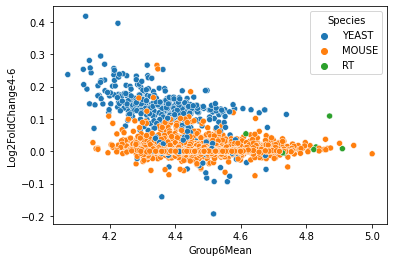

In [6]:
import seaborn as sns


sns.scatterplot(
    data=compared_data.row_annotations,
    x="Group6Mean",
    y="Log2FoldChange4-6",
    hue="Species"
)

In [7]:
cutoffs = np.linspace(0.0, 1.0, num=10000)

In [8]:
precision_roc_data = []

for cutoff in cutoffs[1:]:

    yeast_ids = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue"] <= cutoff) &
        (compared_data.row_annotations["Species"] == "YEAST")
    ].shape[0]

    yeast_fn = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue"] > cutoff) &
        (compared_data.row_annotations["Species"] == "YEAST")
    ].shape[0]

    mouse_ids = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue"] <= cutoff) &
        (compared_data.row_annotations["Species"] == "MOUSE")
    ].shape[0]

    mouse_tn = compared_data.row_annotations[
        (compared_data.row_annotations["CorrectedPValue"] > cutoff) &
        (compared_data.row_annotations["Species"] == "MOUSE")
    ].shape[0]

    recall = yeast_ids / (yeast_ids + yeast_fn)

    precision = yeast_ids / (yeast_ids + mouse_ids)
    fpr = mouse_ids / (mouse_ids + mouse_tn)

    precision_roc_data.append(
        {
            "recall": recall,
            "precision": precision,
            "fpr": fpr
        }
    )


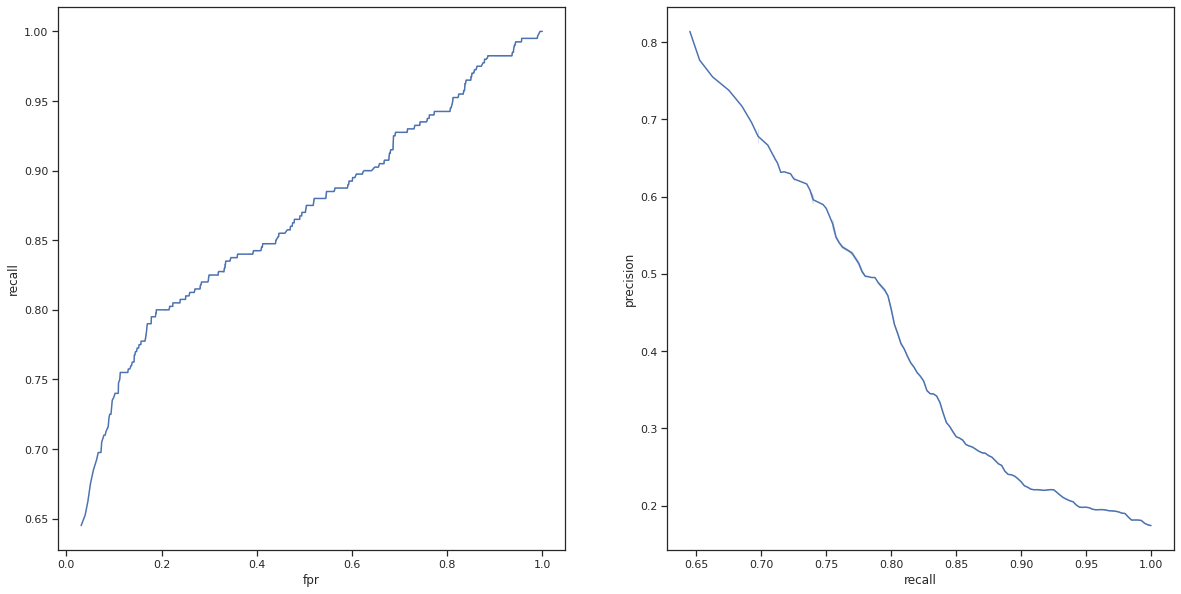

In [9]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

sns.set(font_scale=1, style="ticks")

fig = plt.figure()

gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[1, 1]
)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

sns.lineplot(
    data=pd.DataFrame(precision_roc_data),
    x="fpr",
    y="recall",
    ax=ax1,
)

sns.lineplot(
    data=pd.DataFrame(precision_roc_data),
    x="recall",
    y="precision",
    ax=ax2
)
fig.figure.set_size_inches(20, 10)